In [62]:
import pickle

with open('../data/processed/weatherAU-processed.pkl', 'rb') as f:
    df = pickle.load(f)

df.columns.to_numpy()

array(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed',
       'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
       'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday',
       'RISK_MM', 'RainTomorrow'], dtype=object)

In [63]:
# Set features and target data
features = df[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 
               'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 
               'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
               'Humidity3pm', 'Pressure9am', 'Pressure3pm',  'Cloud9am', 
               'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']]
target = df['RainTomorrow']

# Split dataset into train set and test set with ratio 25:75
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=512)

# Normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [64]:
import matplotlib.pyplot as plt

def plot_roc_curve(fper, tper):
    plt.figure(figsize=(6,4))
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0,1], [0,1], color='darkblue', linestyle='--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver operating characteristics (ROC) curve')
    plt.legend()
    plt.show()

In [65]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, roc_curve, classification_report, ConfusionMatrixDisplay

def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t_0 = time.time()
    if verbose == False:
        model.fit(X_train, y_train, verbose=0)
    else:
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time() - t_0
    
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen Kappa = {}".format(coh_kap))
    print(classification_report(y_test, y_pred, digits=5))
    
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    fper, tper, thresholds = roc_curve(y_test, probs)
    
    plot_roc_curve(fper, tper)
    
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues, normalize='all')
    
    return model, accuracy, roc_auc, coh_kap, time_taken

Accuracy = 0.7907263901899003
ROC Area under Curve = 0.7705930759379449
Cohen Kappa = 0.5509784447680415
              precision    recall  f1-score   support

           0    0.81037   0.85974   0.83433     28790
           1    0.75420   0.68144   0.71598     18182

    accuracy                        0.79073     46972
   macro avg    0.78229   0.77059   0.77515     46972
weighted avg    0.78863   0.79073   0.78852     46972



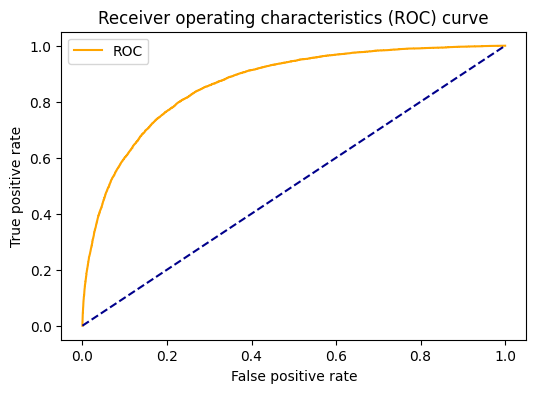

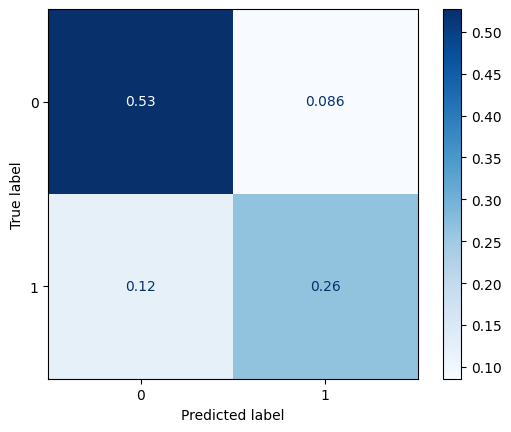

In [66]:
# Training rainfall prediction with different models

# Logistic Regression
from sklearn.linear_model import LogisticRegression
params_lr = {'penalty': 'l1', 'solver': 'liblinear'}
model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

Accuracy = 0.8685174146299923
ROC Area under Curve = 0.86833114093312
Cohen Kappa = 0.7266633587519447
              precision    recall  f1-score   support

           0    0.91218   0.86916   0.89015     28790
           1    0.80722   0.86751   0.83628     18182

    accuracy                        0.86852     46972
   macro avg    0.85970   0.86833   0.86321     46972
weighted avg    0.87155   0.86852   0.86930     46972



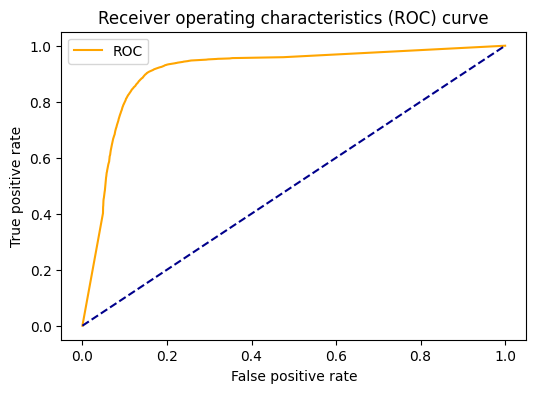

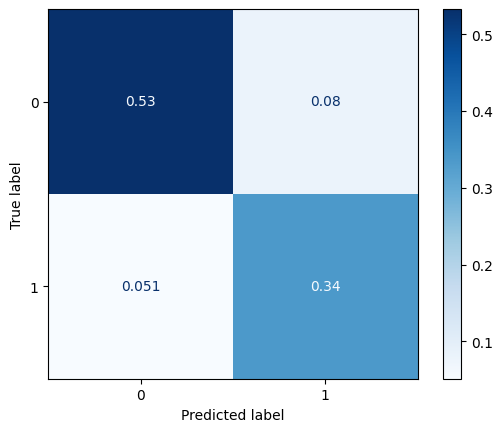

In [67]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
params_dt = {'max_depth': 16, 'max_features': 'sqrt'}
model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy = 0.8763731584773908
ROC Area under Curve = 0.870027964708196
Cohen Kappa = 0.7396137717108578
              precision    recall  f1-score   support

           0    0.89997   0.89812   0.89905     28790
           1    0.83921   0.84193   0.84057     18182

    accuracy                        0.87637     46972
   macro avg    0.86959   0.87003   0.86981     46972
weighted avg    0.87645   0.87637   0.87641     46972



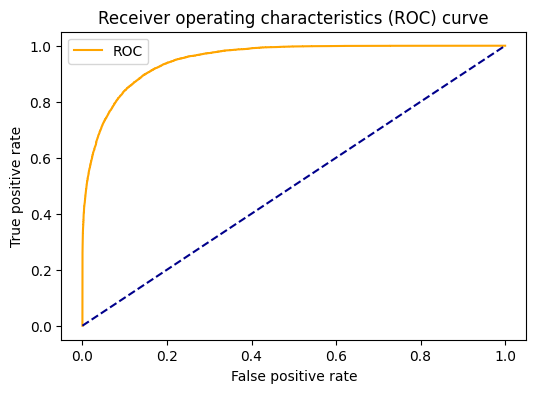

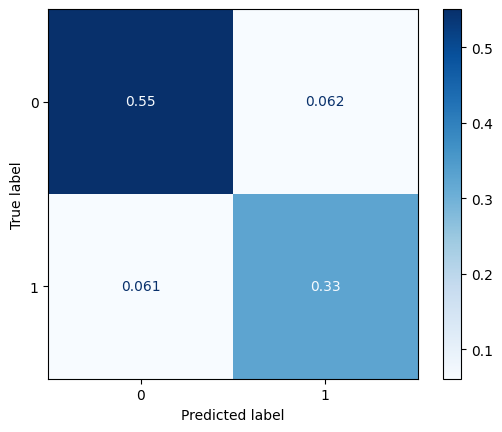

In [68]:
# Neural Network
from sklearn.neural_network import MLPClassifier
params_nn = {
    'hidden_layer_sizes': (30,30,30),
    'activation': 'logistic',
    'solver': 'lbfgs',
    'max_iter': 500
}
model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy = 0.8848250021289279
ROC Area under Curve = 0.8788479107220043
Cohen Kappa = 0.7573735071270696
              precision    recall  f1-score   support

           0    0.90664   0.90531   0.90598     28790
           1    0.85042   0.85238   0.85140     18182

    accuracy                        0.88483     46972
   macro avg    0.87853   0.87885   0.87869     46972
weighted avg    0.88488   0.88483   0.88485     46972



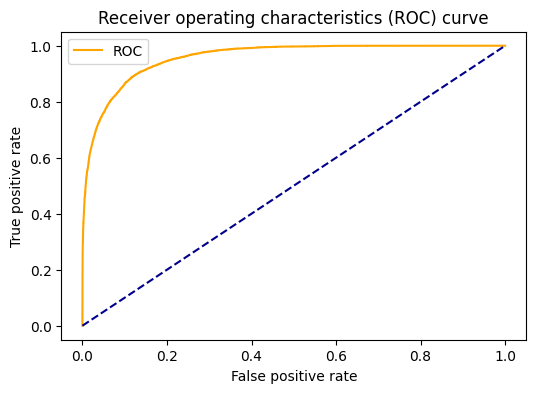

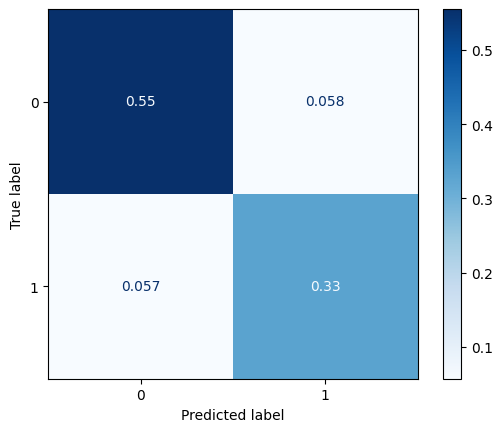

In [69]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
params_rf = {
    'max_depth': 16,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 100,
    'random_state': 512
}
model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_nn, X_train, y_train, X_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy = 0.8839095631440007
ROC Area under Curve = 0.8791650449247506
Cohen Kappa = 0.7560701114763301
              precision    recall  f1-score   support

           0    0.90949   0.90017   0.90481     28790
           1    0.84446   0.85816   0.85125     18182

    accuracy                        0.88391     46972
   macro avg    0.87697   0.87917   0.87803     46972
weighted avg    0.88432   0.88391   0.88408     46972



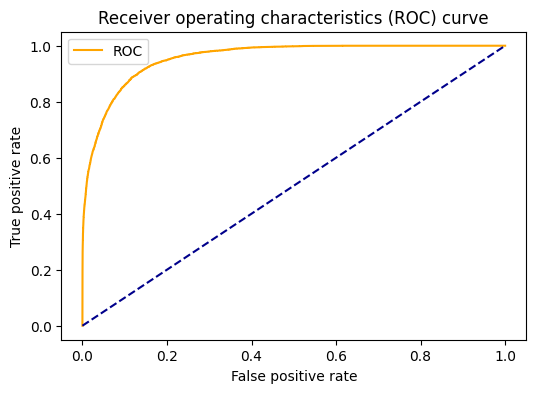

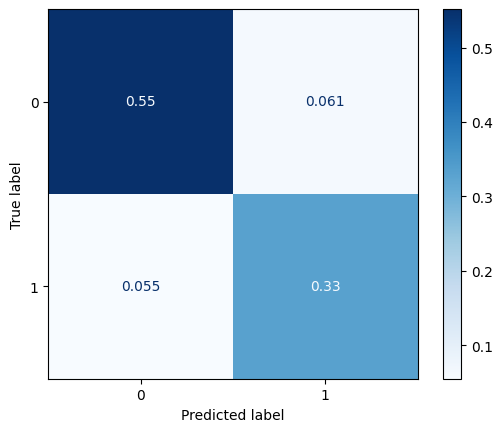

In [70]:
# XGBoost
from xgboost import XGBClassifier
params_xgb = {
    'n_estimators': 500,
    'max_depth': 16
}
model_xgb = XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_nn, X_train, y_train, X_test, y_test)

Accuracy  Time taken
0.790726  1.476109      1
0.868517  0.441119      1
0.876373  218.690246    1
0.883910  231.093054    1
0.884825  210.554188    1
Name: count, dtype: int64


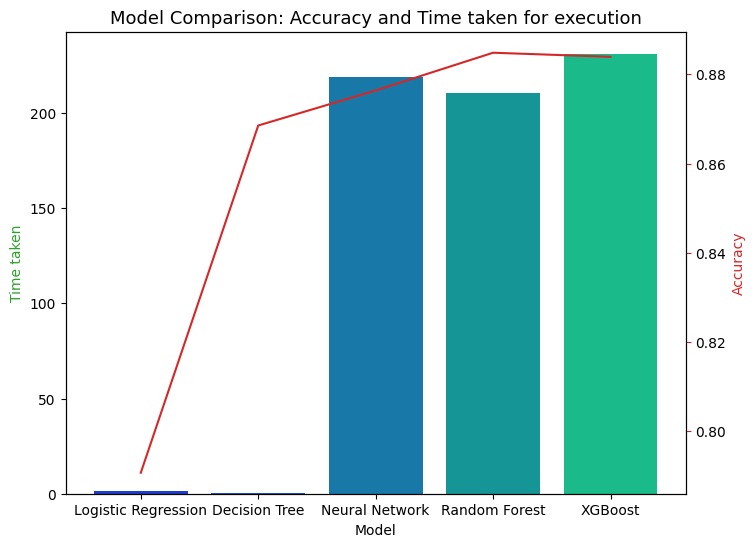

In [71]:
import pandas as pd
import seaborn as sns

accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_nn, accuracy_rf, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_nn, coh_kap_rf, coh_kap_xgb]
tt = [tt_lr, tt_dt, tt_nn, tt_rf, tt_xgb]

model_data = {'Model': ['Logistic Regression','Decision Tree','Neural Network','Random Forest','XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
model_data = pd.DataFrame(model_data)

score = model_data[['Accuracy', 'Time taken']].value_counts()
print(score)

fig, ax1 = plt.subplots(figsize=(8,6))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=10)
ax1.set_ylabel('Time taken', fontsize=10, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = model_data, hue='Model', legend=False, palette='winter')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=10, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = model_data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

ROC_AUC   Cohen_Kappa
0.770593  0.550978       1
0.868331  0.726663       1
0.870028  0.739614       1
0.878848  0.757374       1
0.879165  0.756070       1
Name: count, dtype: int64


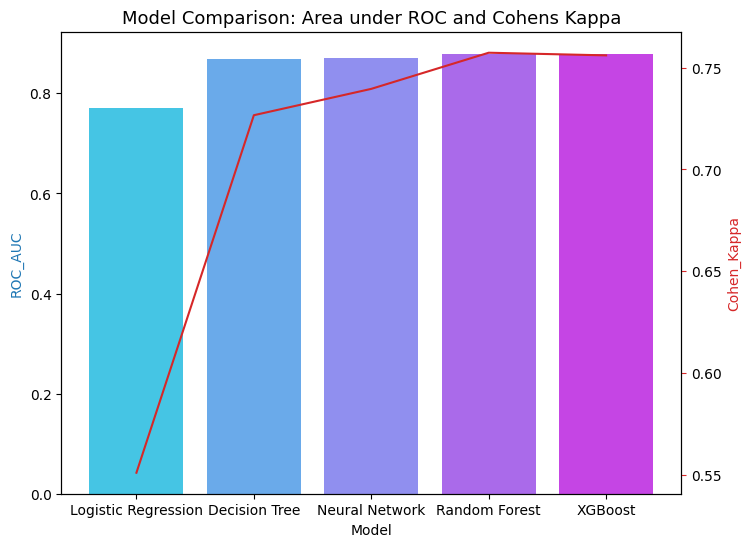

In [72]:
score = model_data[['ROC_AUC', 'Cohen_Kappa']].value_counts()
print(score)

fig, ax3 = plt.subplots(figsize=(8,6))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=10)
ax3.set_ylabel('ROC_AUC', fontsize=10, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = model_data, hue='Model', legend=False, palette='cool')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=10, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = model_data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()